# Machine Learning with OHSU

This notebook investigates the performance of machine learning models to recognize ADHD in subjects. 
This dataset consits of preprocessed data from the OHSU from the ADHD-200 Competition set and the diagnosis corresponding to each subject.

The features for this analysis contains the average signal intensity for each region determined by the AAL atlas. 

This notebook runs two tests to evaluate the accuracy of multiple classification models.
1. Multi-class diagnosis (uses all diagnosis types)
2. Binary classification (if subject has ADHD or not)

## Imports

These are the imports that are required for this notebook to run properly

- `os` to access the file

- `pandas` to work with dataframes

- `numpy` for linear algebra

- `seaborn` for customizable plotting

- `matplotlib.pyplot` for plotting


- `train_test_split()` for splitting data into a training and testing set

- `LogisticRegression` for a logistic regression machine learning model

- `KNeighborsClassifier` for a KNN machine learning model

- `SVC` for a SVM machine learning model

- `LinearDiscriminantAnalysis` for a LDA machine learning model

- `Voting Classifier` for ensemble methods


- `accuracy_score()` to evaluate the accuracy of the model

- `confusion_matrix` and `ConfusionMatrixDisplay` for viewing confusion matrices

- `StratifiedKFold, cross_valscore()` for cross validation

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

### Models

These are the models that will be used in all accuracy evaluations.

In [2]:
# Create a list to hold the models
models = []

# Create the models
logr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])

# Add the models to the list
models.append(('LR', logr))
models.append(('KNN', knn))
models.append(('SVM', svm))
models.append(('LDA', lda))
models.append(('Ensemble', ens))
models.append(('Ensemble Less', ensl))

## Functions

There are basic functions that will be used to create the machine learning model

### get_base_filepath()

Access the filepath for th ebase folder of the project. 
From here, any other asset of the project can be located.

**Input:** None

**Output:** The filepath to the root of the folder

In [3]:
def get_base_filepath():
    '''
    Access the filepath for the base folder of the project
    
    Input: None
    
    Output: The filepath to the root of the folder
    '''
    # Get current directory
    os.path.abspath(os.curdir)

    # Go up a directory level
    os.chdir('..')
    os.chdir('..')

    # Set baseline filepath to the project folder directory
    base_folder_filepath = os.path.abspath(os.curdir)
    return base_folder_filepath

### extract_features()

Create a dataframe using the mean of regions over time.

**Input:** filepath to open the dataframe
    
**Output:** dataframe of correlations between region

In [4]:
def extract_features(filepath):
    '''
    Create a dataframe using the mean of regions over time.
    
    Input: filepath to open the dataframe
    
    Output: dataframe of mean for each region
    '''
    df = pd.read_csv(filepath, sep=r'\s{1,}', engine='python', header=0)
    df = df.drop('File', axis=1)
    df = df.drop('Sub-brick', axis=1)
    return df.mean()

### get_statistics()

Get the descriptive statistics for a list of values
    
**Input:** A list of accuracies
    
**Output:** The mean, std, max, and min for each model's accuracy

In [5]:
def get_statistics(accuracy_list):
    '''
    Get the descriptive statistics for a list of values
    
    Input: A list of accuracies
    
    Output: The mean, std, max, and min for each model's accuracy
    '''
    # Create empty lists for descriptive statistics
    means = []
    stds = []
    maxes = []
    mins = []
    
    # Access the descriptive statistics for each list of accuracies
    for accuracy in accuracy_list:
        accuracy_np = np.array(accuracy)
        means.append(accuracy_np.mean())
        stds.append(accuracy_np.std())
        maxes.append(accuracy_np.max())
        mins.append(accuracy_np.min())
        
    # Create a list for the statistics
    stats = [means, stds, maxes, mins]
    return stats

### make_predictions()

Fit a model using the training data, 
make predictions on a testing set, 
and get the accuracy of the model.

**Input:** 
- A model to use to make predictions
- Set of training features
- Set of testing features
- Set of training targets
- Set of testing targets

**Output:** 
- Predictions for models
- Accuracy of the model


**Dependencies:**
- Used in `evaluate_models()`

In [6]:
def make_predictions(model, X_trn, X_tst, y_trn, y_tst):
    '''
    Get the accuracy of a model
    
    Input:
        - A model to use to make predictions
        - Set of training features
        - Set of testing features
        - Set of training targets
        - Set of testing targets
        
    Output: 
        - Predictions for the model
        - Accuracy of the model
    '''
    
    # Train the model on the training set
    model_fit = model.fit(X_trn, y_trn)
    
    # Make predictions on the testing features
    y_pred = model_fit.predict(X_tst)
    
    # Compare the predictions to the true values
    accuracy = accuracy_score(y_pred, y_tst)
    
    # Return the predictions and accuracy
    return y_pred, accuracy

### evaluate_models()

Evaluate the performance of models on a set of features and targets.

**Input:**
- Set of features
- Set of targets
        
**Output:** 
- Confusion matrices for models
- Accuracy of models

**Dependencies:**
- Uses `make_predictions()`
- Used in `get_accuracies()`

In [7]:
def evaluate_models(X, y):
    '''
    Evaluate the performance of models on a set of features and targets.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - Confusion matrices for models
        - Accuracy of models
    '''
    # Create empty lists to store values
    predictions = dict()
    accuracies = []
    confusion_matrices = []
    
    # Separate the data into training and testing sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y)
    
    # Evaluate the accuracies using each model
    for name, model in models:
        pred, acc = make_predictions(model, X_trn, X_tst, y_trn, y_tst)
        predictions[name] = pred
        accuracies.append(acc)

    # Get the confusion matrix for each set of predictions
    for name, model in models:
        confusion_matrices.append(confusion_matrix(predictions[name], y_tst))
    
    # Return the accuracy and confusion matrices in a list format
    return accuracies, confusion_matrices

### get_accuracies()

Get 100 accuracies for the models

**Input:**
- Set of features
- Set of targets
        
**Output:** 
- List of 100 accuracies for models
- LIst of 100 confusion matrices for models

**Dependencies:**
- Uses `evaluate_models()`

In [8]:
def get_accuracies(X, y):
    '''
    Get 100 accuracies for the models.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - List of 100 accuracies for models
        - LIst of 100 confusion matrices for models
    '''
    
    accuracies = [[],[],[],[],[],[]]
    matrices = [[],[],[],[],[],[]]
    
    # Run 100 iterations of evaluating the model
    for i in range(100):
        # Get the accuracy for this iteration
        accs, cf_matrices = evaluate_models(X, y)
        
        for i in range(len(models)):
            accuracies[i].append(accs[i])
            matrices[i].append(cf_matrices[i])
                   
    # Return a list of all accuracies and confusion matrices
    return accuracies, matrices

### perform_cross_validation()

Use a stratified K-fold for cross validation for the three classification models 

**Input:** 
- A dataframe containing the features use to build the model
- A Series of the true values associated with the feature list
    
**Output:** Printed result for the mean and standard deviation of each model

In [9]:
def perform_cross_validation(X_train, y_train):
    '''
    Input: 
        - A dataframe containing the features use to build the model
        - A Series of the true values associated with the feature list
    
    Output: Printed result for the mean and standard deviation of each model
    '''
    # Create an empty dictionary to store the results
    results = dict()

    # Loop through the models
    for name, model in models:
        # Create a Stratified K-fold for cross validation
        kfold = StratifiedKFold(n_splits=10)
        
        # Apply cross validation using the current model
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        # Add the mean and standard deviation to the dictionary
        results[name] = (cv_results.mean(), cv_results.std())

    # Print the results
    print('Model\t\tCV Mean\t\tCV std')
    print(results)

### get_avg_cfm()

Get the average confusion matrix for a list of 100 matrices
    
**Input:** a list of 100 confusion matrices
    
**Output:** the average confusion matrix

**Dependencies:** Used in `get_model_cfms()`

In [10]:
def get_avg_cfm(cfms):
    '''
    Get the average confusion matrix for a list of 100 matrices
    
    Input: a list of 100 confusion matrices
    
    Output: the average confusion matrix
    '''
    # Create an empty confusion matrix based on the size
    if len(cfms[0]) == 2:
        cfm = [[0,0],
                [0,0]]
    else:
        cfm = [[0,0,0,0],
               [0,0,0,0],
               [0,0,0,0],
               [0,0,0,0]]
          
            
    # Sum up the values for each index in the confusion matrix
    for matrix in cfms:
        for row in range(len(matrix)):
            for col in range(len(matrix[row])):
                # If the row or column are out of bounds, skip it and move on
                if (len(matrix)==3 and len(cfm)==4) and (col==3 or row==3):
                    continue
                    
                # If the row or column is at diagnosis 2 and the matrix is the incorrect size, move on
                elif (len(matrix)==3 and len(cfm)==4) and (col==2 or row==2):
                    continue
                    
                # Otherwise, add the element to the sum matrix
                cfm[row][col] += matrix[col][row]
                
                
    # Divide by the number of values in the set
    for row in range(len(cfm)):
        for col in range(len(cfm[row])):
            cfm[row][col] /=100       
    
    # Return the mean confusion matrix
    return cfm

### get_model_cfms()

Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
**Input:** A list of the confusion matrices for each model
    
**Output:** The average confusion matrix for each model

**Dependencies:**
- Uses `get_avg_cfm()`
- Used in `print_model_cfms()`

In [11]:
def get_model_cfms(cfms):
    '''
    Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
    Input: A list of the confusion matrices for each model
    
    Output: The average confusion matrix for each model
    '''
    # Create an empty list to store the average confusion matrices in
    model_cfms = []
    
    # Get the average cfm for each model type
    for cfm_set in cfms:
        model_cfms.append(get_avg_cfm(cfm_set))
    
    # Return the average confusion matrices for each model type
    return model_cfms

### print_confusion_matrix()

Print a confusion matrix

**Input:**

- Confusion matrix to print
- A string to make a more clear title for the graph
        
**Ouput:** Display the confusion matrix

**Dependencies:**
- Used in `print_model_cfms()`

In [12]:
def print_confusion_matrix(cmf, name):
    '''
    Print a confusion matrix
    
    Input:
        - Confusion matrix to print
        - A string to make a more clear title for the graph
        
    Ouput: Display the confusion matrix
    '''
    # Create matrix part of heatmape
    sns.heatmap(cmf,
            annot=True,
        )
    
    # Make graph labels
    plt.ylabel('Actual')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix for ' + name)
        
    # Display graph
    plt.show()

### print_model_cfms()

Print all model confusion matrices 
    
**Input:** A list of confusion matrices for each model
    
**Output:** Average confusion matrix for each model printed

**Dependencies:**
- Uses `get_model_cfms()`
- Uses `print_confusion_matrix()`

In [13]:
def print_model_cfms(cfms):
    '''
    Print all model confusion matrices 
    
    Input: A list of confusion matrices for each model
    
    Output: Average confusion matrix for each model printed
    '''
    for i, (name, model) in enumerate(models):
        plt.figure(figsize=(3,2))
        print_confusion_matrix(get_model_cfms(cfms)[i], name)

### print_training_cfm()

Print the confusion matrix for the training data
    
**Input:** features and targets
    
**Output:** The 6 model's confusion matrices outputted

In [14]:
def print_training_cfm(X_, y_):
    '''
    Print the confusion matrix for the training data
    
    Input: features and targets
    
    Output: The 6 model's confusion matrices outputted
    '''
    # Split the data into the same training and testing as when in feature selection
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_, y_, random_state=1)
    
    classifiers = {
        'Logisitic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'LDA': LinearDiscriminantAnalysis(),
        'Ensemble': VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)]),
        'Ensemble (less)':VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])
    }

    f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')
        
    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.fit(X_trn, y_trn).predict(X_tst)
        cf_matrix = confusion_matrix(y_tst, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

--------------------------------------------------------------------------------------------------------------------------------

## Open files

In this section, the files for all of the patients is opened and combined into two matrices to build a dataframe in the next section.

###  Filepaths

Access the filepath to the OHSU folder. 
This is where the data for all of the patients at the OHSU site are located.

In [15]:
base_folder_filepath = get_base_filepath()
ohsu_filepath = base_folder_filepath +  '\\Data\\Preprocessed_data\\Sites\\OHSU\\'
phenotypics_filepath = base_folder_filepath + '\\Data\\Phenotypic\\Sites\\OHSU_phenotypic.csv'

### Subjects

Open the 'sfnwmrda' file for each subject at the OHSU site. 

Add the features to a matrix and the subjects to a different matrix.

In [16]:
subjects = []
subject_features = []

# Access all sfnwmrda files in the OHSU folder
# Access the patient folders within the site folder
for patient_id_folder in os.listdir(ohsu_filepath):
    # Access the filepath to the folder
    patient_id_folder_path = os.path.join(ohsu_filepath, patient_id_folder)
    
    subjects.append(patient_id_folder)
    
    # Check if the filepath is a folder, continue if it is a folder
    if os.path.isdir(patient_id_folder_path):
        # Get the file name (dependent on folder name)
        file_name = f"sfnwmrda{patient_id_folder}_session_1_rest_1_aal_TCs.1D"
        
        # Join the file name to its path
        file_path = os.path.join(patient_id_folder_path, file_name)
        
        # Extract the features and add it to the list of subjects
        subject_features.append(extract_features(file_path))

--------------------------------------------------------------------------------------------------------------------------------

# Multi-Class Classificaiton

This section investigates how models perform when predicting the type of ADHD the subject has or if they are a control.

This is accomplished by extracting the diagnosis from the phenotypic data and adding it to the regions. 
Each number corresponds to a type diagnosis for ADHD.

    0 = TDC (Typically developing children)
    1 = ADHD-Combined
    2 = ADHD-Hyperactive/Impulsive
    3 = ADHD-Inattentive

### Subject x Region

Using the code from the previous cell, build a matrix of subjects vs. regions.

In [17]:
df_subject_x_region = pd.DataFrame(subject_features, index=subjects)
df_subject_x_region.head()

,Mean_2001,Mean_2002,Mean_2101,Mean_2102,Mean_2111,Mean_2112,Mean_2201,Mean_2202,Mean_2211,Mean_2212,...,Mean_9081,Mean_9082,Mean_9100,Mean_9110,Mean_9120,Mean_9130,Mean_9140,Mean_9150,Mean_9160,Mean_9170
1084283,0.001087,0.006426,0.003046,0.007911,0.002836,0.010834,0.014295,0.013514,0.000804,0.044241,...,0.020710,0.027268,0.029133,0.005323,-0.006976,-0.010725,-0.018854,-0.017208,-0.021859,0.033943
1084884,-0.002832,0.032711,-0.019582,-0.008242,-0.006916,-0.009639,-0.020090,-0.014911,-0.025029,-0.025237,...,-0.004995,-0.013224,-0.051607,0.011342,-0.006839,0.000509,-0.021160,-0.012922,-0.022561,-0.031755
1108916,-0.015434,-0.013533,0.006497,-0.003192,0.002811,0.004337,-0.003781,-0.006387,-0.008912,0.004389,...,0.000488,0.002434,0.018162,-0.022221,-0.020608,-0.010677,-0.022314,0.001143,0.010789,0.010671
1206380,-0.001697,0.003231,-0.008367,-0.006932,-0.009974,-0.000491,-0.003736,-0.007092,-0.001125,0.002679,...,0.004499,0.001607,0.016533,0.000625,0.002733,-0.021268,-0.016480,-0.003075,0.007536,0.013510
1340333,-0.007934,0.002444,-0.004535,-0.004931,0.004147,-0.003268,-0.018939,-0.009468,-0.004490,-0.004108,...,0.009226,-0.007520,0.026861,0.017277,-0.016428,-0.018125,-0.006291,-0.021627,-0.021855,0.040774


### Diagnosis

Add the subject's diagnosis to the dataframe

Read the phenotypic file as a dataframe.

Extract the diagnosis as a numpy array.

In [18]:
df_phenotypic = pd.read_csv(phenotypics_filepath, index_col='ScanDir ID')
diagnosis = df_phenotypic['DX'].to_numpy()

Add the diagnosis to a new dataframe

In [19]:
df_region_w_dx = df_subject_x_region.copy()

df_region_w_dx['DX'] = diagnosis

df_region_w_dx.head()

,Mean_2001,Mean_2002,Mean_2101,Mean_2102,Mean_2111,Mean_2112,Mean_2201,Mean_2202,Mean_2211,Mean_2212,...,Mean_9082,Mean_9100,Mean_9110,Mean_9120,Mean_9130,Mean_9140,Mean_9150,Mean_9160,Mean_9170,DX
1084283,0.001087,0.006426,0.003046,0.007911,0.002836,0.010834,0.014295,0.013514,0.000804,0.044241,...,0.027268,0.029133,0.005323,-0.006976,-0.010725,-0.018854,-0.017208,-0.021859,0.033943,1
1084884,-0.002832,0.032711,-0.019582,-0.008242,-0.006916,-0.009639,-0.020090,-0.014911,-0.025029,-0.025237,...,-0.013224,-0.051607,0.011342,-0.006839,0.000509,-0.021160,-0.012922,-0.022561,-0.031755,0
1108916,-0.015434,-0.013533,0.006497,-0.003192,0.002811,0.004337,-0.003781,-0.006387,-0.008912,0.004389,...,0.002434,0.018162,-0.022221,-0.020608,-0.010677,-0.022314,0.001143,0.010789,0.010671,1
1206380,-0.001697,0.003231,-0.008367,-0.006932,-0.009974,-0.000491,-0.003736,-0.007092,-0.001125,0.002679,...,0.001607,0.016533,0.000625,0.002733,-0.021268,-0.016480,-0.003075,0.007536,0.013510,3
1340333,-0.007934,0.002444,-0.004535,-0.004931,0.004147,-0.003268,-0.018939,-0.009468,-0.004490,-0.004108,...,-0.007520,0.026861,0.017277,-0.016428,-0.018125,-0.006291,-0.021627,-0.021855,0.040774,1


## Model

Build a machine learning model and use it to make predictions on the dataset. 
Evaluate the model based on its accuracy.

Separate the data into features and targets

In [20]:
X = df_region_w_dx.drop('DX', axis=1)
y = df_region_w_dx['DX']

### Build a model and make predictions

Logistic Regression

In [21]:
model_LR = LogisticRegression().fit(X, y)
y_pred_LR = model_LR.predict(X)

accuracy_LR = accuracy_score(y_pred_LR, y)
accuracy_LR

0.5443037974683544

KNN

In [22]:
model_KNN = KNeighborsClassifier().fit(X, y)
y_pred_KNN = model_KNN.predict(X)

accuracy_KNN = accuracy_score(y_pred_KNN, y)
accuracy_KNN

0.5949367088607594

SVM

In [23]:
model_SVM = SVC().fit(X, y)
y_pred_SVM = model_SVM.predict(X)

accuracy_SVM = accuracy_score(y_pred_SVM, y)
accuracy_SVM

0.6962025316455697

## Evaluate Accuracy

Understand the model accuracies better

### Best model

Based on the results from the model building, SVM had the best accuracy.

In [24]:
print('Accuracies:')
print('\nLogistic Regression:\t', accuracy_LR)
print('KNN:\t\t\t', accuracy_KNN)
print('SVM:\t\t\t', accuracy_SVM)

Accuracies:

Logistic Regression:	 0.5443037974683544
KNN:			 0.5949367088607594
SVM:			 0.6962025316455697


### Add the predictions to the model

In [25]:
df_w_preds = df_region_w_dx.copy()

df_w_preds['DX_pred'] = y_pred_SVM
df_w_preds.head()

,Mean_2001,Mean_2002,Mean_2101,Mean_2102,Mean_2111,Mean_2112,Mean_2201,Mean_2202,Mean_2211,Mean_2212,...,Mean_9100,Mean_9110,Mean_9120,Mean_9130,Mean_9140,Mean_9150,Mean_9160,Mean_9170,DX,DX_pred
1084283,0.001087,0.006426,0.003046,0.007911,0.002836,0.010834,0.014295,0.013514,0.000804,0.044241,...,0.029133,0.005323,-0.006976,-0.010725,-0.018854,-0.017208,-0.021859,0.033943,1,0
1084884,-0.002832,0.032711,-0.019582,-0.008242,-0.006916,-0.009639,-0.020090,-0.014911,-0.025029,-0.025237,...,-0.051607,0.011342,-0.006839,0.000509,-0.021160,-0.012922,-0.022561,-0.031755,0,0
1108916,-0.015434,-0.013533,0.006497,-0.003192,0.002811,0.004337,-0.003781,-0.006387,-0.008912,0.004389,...,0.018162,-0.022221,-0.020608,-0.010677,-0.022314,0.001143,0.010789,0.010671,1,0
1206380,-0.001697,0.003231,-0.008367,-0.006932,-0.009974,-0.000491,-0.003736,-0.007092,-0.001125,0.002679,...,0.016533,0.000625,0.002733,-0.021268,-0.016480,-0.003075,0.007536,0.013510,3,0
1340333,-0.007934,0.002444,-0.004535,-0.004931,0.004147,-0.003268,-0.018939,-0.009468,-0.004490,-0.004108,...,0.026861,0.017277,-0.016428,-0.018125,-0.006291,-0.021627,-0.021855,0.040774,1,0


### Understand the differences

View the value counts to better understand how the predictions and true values are distributed.

The model was abel to recognize 3 out of the 4 diagnosis types. The frequency follows a similar frequency to the true values

In [26]:
df_w_preds['DX_pred'].value_counts()

DX_pred
0    66
1    12
3     1
Name: count, dtype: int64

In [27]:
df_w_preds['DX'].value_counts()

DX
0    42
1    23
3    12
2     2
Name: count, dtype: int64

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the models.

In [28]:
accs, cfms = get_accuracies(X, y)

#### View Confusion Matrices

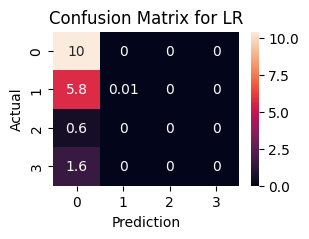

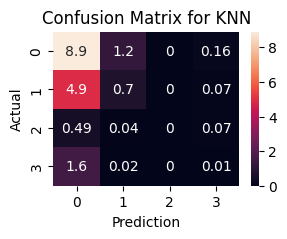

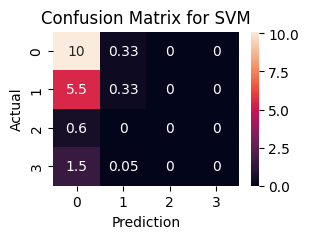

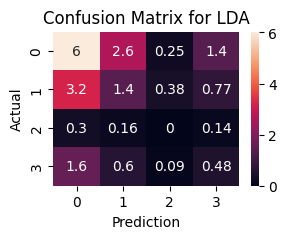

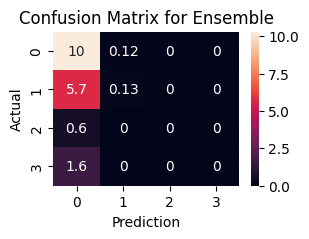

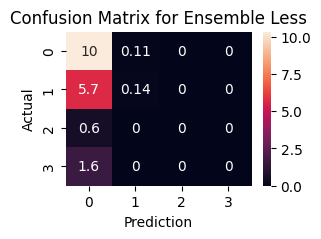

In [29]:
print_model_cfms(cfms)

Extract descriptive statistics from the accuracies.

In [30]:
stats = get_statistics(accs)
results = pd.DataFrame(stats, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass', 'KNN_multiclass', 
                                'SVM_multiclass', 'LDA_multiclass', 
                                'Ensemble_multiclass', 'Ensemble2_multiclass'])

results

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass
Mean,0.522500,0.481000,0.522000,0.399000,0.522000,0.523500
STD,0.102561,0.101926,0.100578,0.091373,0.100578,0.101601
Max,0.750000,0.750000,0.750000,0.650000,0.700000,0.700000
Min,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000


#### Cross-validation

Perform cross validation on this dataset with the models from before. This is done to compare the results to the train-test split method.

In [31]:
perform_cross_validation(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5321428571428571, 0.05101020306102036), 'KNN': (0.5196428571428571, 0.1534987369488686), 'SVM': (0.5446428571428571, 0.09723538135758558), 'LDA': (0.39107142857142857, 0.15980895801307413), 'Ensemble': (0.5321428571428571, 0.09408528480228207), 'Ensemble Less': (0.5321428571428571, 0.09408528480228207)}


### Conclusion

The most accurate model was SVM, closely followed by logistic regression in the tran/test split.
Cross validation supports SVM as the most accurate model with logisitc regression, ensemble, and ensemble less sharing the second highest accuracy.

--------------------------------------------------------------------------------------------------------------------------------

# Binary Classification

This section investigates how models perform when predicting whether a patient has ADHD or not. 

This is accomplished by converting the diagnosis to a binary value based on if their diagnosis is a control or has some type of ADHD. 
For this feature, 'True' signifies the subject has ADHD and 'False' signifies the subject is a control and does not have ADHD.

Theoretically, this model should perform better than the multi-class classification since it is simpler.

## Build the dataframe

Create a dataframe of the subjects, regions and their diagnosis.

### Combine

Add the diagnosis Series to the regions dataframe.

In [32]:
# Make a copy of the region dataframe
df_region_w_dx_binary = df_subject_x_region.copy()

# Add the diagnosis to the region dataframe
df_region_w_dx_binary['DX'] = diagnosis>0

df_region_w_dx_binary.head()

,Mean_2001,Mean_2002,Mean_2101,Mean_2102,Mean_2111,Mean_2112,Mean_2201,Mean_2202,Mean_2211,Mean_2212,...,Mean_9082,Mean_9100,Mean_9110,Mean_9120,Mean_9130,Mean_9140,Mean_9150,Mean_9160,Mean_9170,DX
1084283,0.001087,0.006426,0.003046,0.007911,0.002836,0.010834,0.014295,0.013514,0.000804,0.044241,...,0.027268,0.029133,0.005323,-0.006976,-0.010725,-0.018854,-0.017208,-0.021859,0.033943,True
1084884,-0.002832,0.032711,-0.019582,-0.008242,-0.006916,-0.009639,-0.020090,-0.014911,-0.025029,-0.025237,...,-0.013224,-0.051607,0.011342,-0.006839,0.000509,-0.021160,-0.012922,-0.022561,-0.031755,False
1108916,-0.015434,-0.013533,0.006497,-0.003192,0.002811,0.004337,-0.003781,-0.006387,-0.008912,0.004389,...,0.002434,0.018162,-0.022221,-0.020608,-0.010677,-0.022314,0.001143,0.010789,0.010671,True
1206380,-0.001697,0.003231,-0.008367,-0.006932,-0.009974,-0.000491,-0.003736,-0.007092,-0.001125,0.002679,...,0.001607,0.016533,0.000625,0.002733,-0.021268,-0.016480,-0.003075,0.007536,0.013510,True
1340333,-0.007934,0.002444,-0.004535,-0.004931,0.004147,-0.003268,-0.018939,-0.009468,-0.004490,-0.004108,...,-0.007520,0.026861,0.017277,-0.016428,-0.018125,-0.006291,-0.021627,-0.021855,0.040774,True


View the number of subjects with and without ADHD.

In [33]:
df_region_w_dx_binary['DX'].value_counts()

DX
False    42
True     37
Name: count, dtype: int64

## Evaluate Accuracy

Build models and evaluate the accuracy

Separate dataframe into features and targets

In [34]:
X_binary = df_region_w_dx_binary.drop('DX', axis=1)
y_binary = df_region_w_dx_binary['DX']

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the models.

In [35]:
accs_binary, cfm_binary = get_accuracies(X_binary, y_binary)

#### View Confusion Matrices

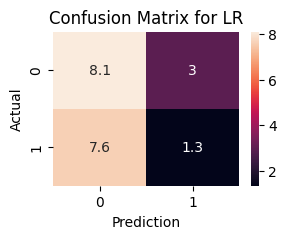

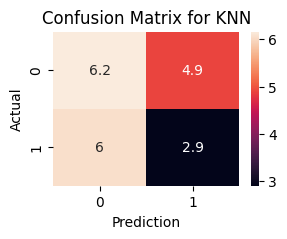

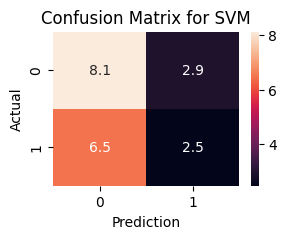

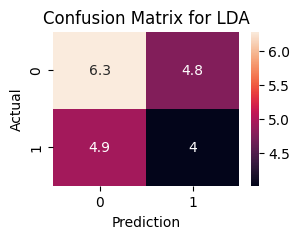

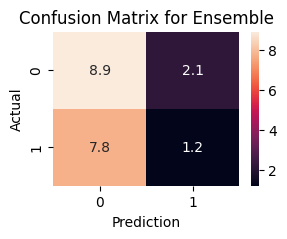

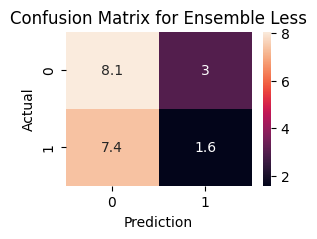

In [36]:
print_model_cfms(cfm_binary)

Extract descriptive statistics from the accuracies.

In [37]:
stats_binary = get_statistics(accs_binary)
results_binary = pd.DataFrame(stats_binary, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary', 'KNN_binary', 
                                       'SVM_binary', 'LDA_binary', 
                                       'Ensemble_binary', 'Ensemble2_binary'])

results_binary

,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.472000,0.453000,0.53000,0.515000,0.505500,0.482500
STD,0.120482,0.108356,0.09975,0.099121,0.086283,0.102561
Max,0.700000,0.700000,0.70000,0.800000,0.750000,0.750000
Min,0.150000,0.150000,0.15000,0.250000,0.200000,0.150000


#### Cross-validation

Perform cross validation on this dataset with the models from before. This is done to compare the results to the train-test split method.

In [38]:
perform_cross_validation(X_binary, y_binary)

Model		CV Mean		CV std
{'LR': (0.5446428571428571, 0.056610241014812), 'KNN': (0.4428571428571429, 0.12647093721161268), 'SVM': (0.5589285714285714, 0.12321428571428572), 'LDA': (0.5035714285714286, 0.15273860557387928), 'Ensemble': (0.5071428571428571, 0.09916745269224872), 'Ensemble Less': (0.5321428571428571, 0.10943966747174687)}


### Conclusion

The most accurate model from this test is SVM in train/test split and cross-validation. 
Cross-validation also has logistic regression and ensemble less in close second and third, but this is not reflected in the tran/test split results.

--------------------------------------------------------------------------------------------------------------------------------

# Export Results

Combine the results from both tests in the notebook to a single dataframe. 
Save this dataframe as a file in the results folder of this repository.

Combine results

In [39]:
results_complete = pd.concat([results, results_binary], axis=1)
results_complete

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.522500,0.481000,0.522000,0.399000,0.522000,0.523500,0.472000,0.453000,0.53000,0.515000,0.505500,0.482500
STD,0.102561,0.101926,0.100578,0.091373,0.100578,0.101601,0.120482,0.108356,0.09975,0.099121,0.086283,0.102561
Max,0.750000,0.750000,0.750000,0.650000,0.700000,0.700000,0.700000,0.700000,0.70000,0.800000,0.750000,0.750000
Min,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.150000,0.150000,0.15000,0.250000,0.200000,0.150000


Export dataframe

In [40]:
results_complete.to_csv('Results\\2023.6.30-Region_Correlation-Results-OHSU.csv')